In [744]:
#################### DOWNLOAD AND UNZIP FILE SAVED IN DRIVE ####################

!pip install -U -q PyDrive

# HERE YOUR FILE ID ( GET IT WITH THE SHARING URL: https://drive.google.com/open?id=1Soh3zXLXt2lT7b_3FcWWyeOCC7SnOxK0 )
zip_id = '1OiDe5XYrAMBzOZTrR6q3vg4R1xjfCwFW'
# https://drive.google.com/file/d/1OiDe5XYrAMBzOZTrR6q3vg4R1xjfCwFW/view?usp=sharing
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('ECommerce'):
    os.makedirs('ECommerce')

# DOWNLOAD ZIP
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('ECommerce.zip')

# UNZIP ZIP
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('ECommerce.zip', 'r')
zip_ref.extractall('ECommerce/')
zip_ref.close()

Uncompressing zip file


In [745]:
!ls

adc.json			 catboost_info	  cb_preds.xlsx  ECommerce.zip
catboost_feature_importance.png  cb_lg_6040.xlsx  ECommerce	 sample_data


In [746]:
!ls '/content/ECommerce'

E-Commerce_Participants_Data  __MACOSX


In [747]:
!ls '/content/ECommerce/E-Commerce_Participants_Data'

Sample_Submission.xlsx	Test.csv  Train.csv


### Load Packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns  
from sklearn import metrics, preprocessing, model_selection
from sklearn.model_selection import train_test_split
# from ngboost import NGBRegressor
# from ngboost.learners import default_tree_learner
# from ngboost.distns import Normal
# from ngboost.scores import MLE
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import r2_score
import datetime 
import time
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt

%matplotlib inline

SEED = 1

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Read the dataset

In [0]:
file = r'/content/ECommerce/E-Commerce_Participants_Data/'
train_df = pd.read_csv(file+'Train.csv')
test_df = pd.read_csv(file+'Test.csv')
sub_df = pd.read_excel(file+'Sample_Submission.xlsx')

In [750]:
train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


In [751]:
test_df.head()


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,1/12/2018
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,20/12/2012
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,1/12/2014
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,1/12/2019
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,1/12/2017


In [752]:
sub_df.head()

,Selling_Price
0,2921.95
1,508.47
2,802.71
3,402.79
4,751.10


In [753]:
print(train_df.shape, test_df.shape)

(2452, 8) (1051, 7)


In [754]:
print(f'Number of samples in train: {train_df.shape[0]}')
print(f'Number of columns in train: {train_df.shape[1]}')
for col in train_df.columns:
    if train_df[col].isnull().any():
        print(col, train_df[col].isnull().sum())

Number of samples in train: 2452
Number of columns in train: 8


In [755]:
print(f'Number of samples in test: {test_df.shape[0]}')
print(f'Number of columns in test: {test_df.shape[1]}')
for col in test_df.columns:
    if test_df[col].isnull().any():
        print(col, test_df[col].isnull().sum())

Number of samples in test: 1051
Number of columns in test: 7


In [756]:
train_df.dtypes

Product           object
Product_Brand     object
Item_Category     object
Subcategory_1     object
Subcategory_2     object
Item_Rating      float64
Date              object
Selling_Price    float64
dtype: object

In [757]:
train_df.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
Selling_Price    0
dtype: int64

In [758]:
test_df.isnull().sum()

Product          0
Product_Brand    0
Item_Category    0
Subcategory_1    0
Subcategory_2    0
Item_Rating      0
Date             0
dtype: int64

In [759]:
train_df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'Selling_Price'],
      dtype='object')

In [760]:
#find overlap between train and test sets
cols =  [
            'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2'
          ]
for col in cols:
  print('Total unique'+col  +' values in Train are {}'.format(train_df[col].nunique()))
  print('Total unique'+col  +' values in Test are {}'.format(test_df[col].nunique()))
  print('Common'+col +' values are {}'.format(len(list(set(train_df[col]) & set(test_df[col])))))
  print('**************************')

Total uniqueProduct_Brand values in Train are 1010
Total uniqueProduct_Brand values in Test are 494
CommonProduct_Brand values are 191
**************************
Total uniqueItem_Category values in Train are 75
Total uniqueItem_Category values in Test are 47
CommonItem_Category values are 27
**************************
Total uniqueSubcategory_1 values in Train are 130
Total uniqueSubcategory_1 values in Test are 93
CommonSubcategory_1 values are 81
**************************
Total uniqueSubcategory_2 values in Train are 336
Total uniqueSubcategory_2 values in Test are 194
CommonSubcategory_2 values are 135
**************************


In [0]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['Missing %'] = ((df.isnull().sum().values)/ (df.shape[0])) *100
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [762]:
resumetable(train_df)

Dataset Shape: (2452, 8)


,Name,dtypes,Missing,Uniques,Missing %,First Value,Second Value,Third Value,Entropy
0,Product,object,0,2452,0.0,P-2610,P-2453,P-6802,11.26
1,Product_Brand,object,0,1010,0.0,B-659,B-3078,B-1810,7.42
2,Item_Category,object,0,75,0.0,bags wallets belts,clothing,home decor festive needs,3.70
3,Subcategory_1,object,0,130,0.0,bags,women s clothing,showpieces,5.06
4,Subcategory_2,object,0,336,0.0,hand bags,western wear,ethnic,6.24
5,Item_Rating,float64,0,41,0.0,4.3,3.1,3.5,5.33
6,Date,object,0,483,0.0,2/3/2017,7/1/2015,1/12/2019,7.54
7,Selling_Price,float64,0,1095,0.0,291,897,792,9.54


In [763]:
resumetable(test_df)

Dataset Shape: (1051, 7)


,Name,dtypes,Missing,Uniques,Missing %,First Value,Second Value,Third Value,Entropy
0,Product,object,0,1051,0.0,P-11284,P-6580,P-5843,10.04
1,Product_Brand,object,0,494,0.0,B-2984,B-1732,B-3078,6.74
2,Item_Category,object,0,47,0.0,computers,jewellery,clothing,3.64
3,Subcategory_1,object,0,93,0.0,network components,bangles bracelets armlets,women s clothing,4.92
4,Subcategory_2,object,0,194,0.0,routers,bracelets,western wear,5.94
5,Item_Rating,float64,0,41,0.0,4.3,3,1.5,5.31
6,Date,object,0,318,0.0,1/12/2018,20/12/2012,1/12/2014,7.35


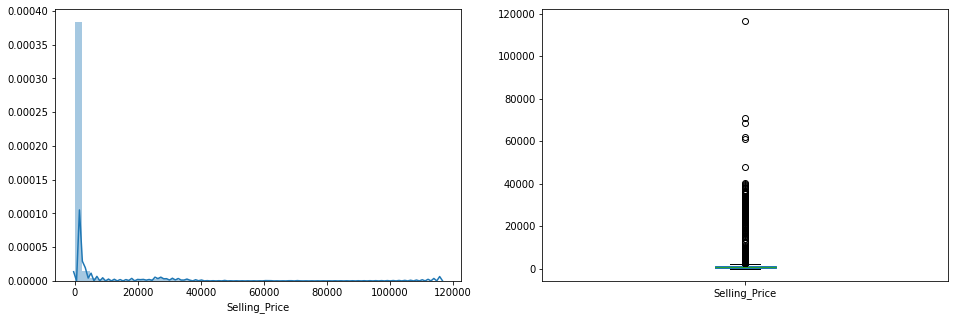

In [764]:
plt.figure(1)
plt.subplot(121)
sns.distplot(train_df['Selling_Price'])


plt.subplot(122)
train_df['Selling_Price'].plot.box(figsize=(16,5))

plt.show()

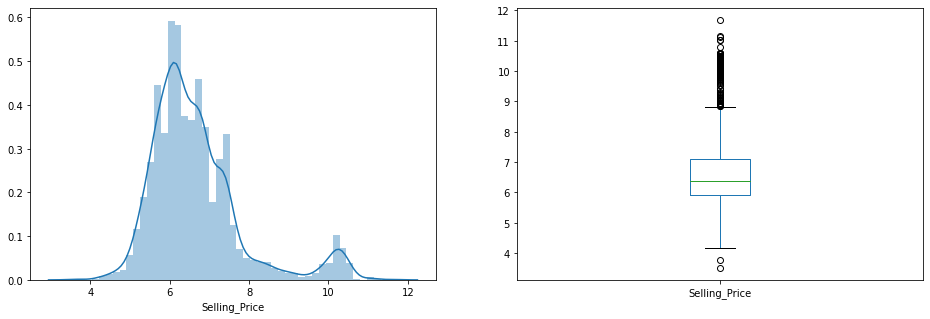

In [765]:
plt.figure(1)
plt.subplot(121)
sns.distplot(np.log1p(train_df['Selling_Price']))


plt.subplot(122)
np.log1p(train_df['Selling_Price']).plot.box(figsize=(16,5))

plt.show()

In [0]:
#Testing for resampling
resampled_train_df = train_df.copy()
resampled_test_df = test_df.copy()

### Feature Engineering

In [0]:
# * join the datasets
train_df['is_train']  = 1
test_df['Selling_Price'] = 0
test_df['is_train'] = 0

In [0]:
full_df = train_df.append(test_df)

In [0]:
full_df['Date'] = pd.to_datetime(full_df['Date'])

In [770]:
full_df['Date'].min(), full_df['Date'].max()

(Timestamp('2012-01-12 00:00:00'), Timestamp('2020-12-06 00:00:00'))

In [0]:
# full_df['days_since_last_purchase'] = (datetime.datetime(2020, 12, 6) - full_df['Date']).dt.days

In [0]:
def create_date_featues(df):
    df['Year'] = pd.to_datetime(df['Date']).dt.year
    df['Month'] = pd.to_datetime(df['Date']).dt.month
    df['Day'] = pd.to_datetime(df['Date']).dt.day
    df['Dayofweek'] = pd.to_datetime(df['Date']).dt.dayofweek
    df['DayOfyear'] = pd.to_datetime(df['Date']).dt.dayofyear
    df['Week'] = pd.to_datetime(df['Date']).dt.week 
    df['Quarter'] = pd.to_datetime(df['Date']).dt.quarter  
    df['Is_month_start'] = pd.to_datetime(df['Date']).dt.is_month_start 
    df['Is_month_end'] = pd.to_datetime(df['Date']).dt.is_month_end 
    df['Is_quarter_start'] = pd.to_datetime(df['Date']).dt.is_quarter_start
    df['Is_quarter_end'] = pd.to_datetime(df['Date']).dt.is_quarter_end 
    df['Is_year_start'] = pd.to_datetime(df['Date']).dt.is_year_start 
    df['Is_year_end'] = pd.to_datetime(df['Date']).dt.is_year_end
    df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)   
    df['Is_weekday'] = np.where(df['Dayofweek'].isin([0,1,2,3,4]),1,0)
    df['Days_in_month'] = pd.to_datetime(df['Date']).dt.days_in_month 
    return df

In [0]:
full_df = create_date_featues(full_df)

In [774]:
full_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0,1,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0,1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0,1,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,1,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,1,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31


In [0]:
Product_Brand_Day_grpd = full_df.groupby(['Product_Brand', 'Day']).agg({'Item_Rating': ['mean', 'max', 'min'],
                                                     'Subcategory_1': ['nunique'], 
                                                     'Subcategory_2': ['nunique'],
                                                     'Item_Category': ['nunique']  
                                                     })
Product_Brand_Day_grpd.columns = ['grpd_by_Product_Brand_Day_' + '_'.join(c).strip('_') for c in Product_Brand_Day_grpd.columns]
full_df = pd.merge(full_df, Product_Brand_Day_grpd, on = ['Product_Brand', 'Day'], how='left')


In [0]:
Subcategory_1_Day_grpd = full_df.groupby(['Subcategory_1', 'Day']).agg({'Item_Rating': ['mean', 'max', 'min'],
                                                     'Product_Brand': ['nunique'], 
                                                     'Subcategory_2': ['nunique'],
                                                     'Item_Category': ['nunique'] 
                                                     })
Subcategory_1_Day_grpd.columns = ['grpd_by_Subcategory_1_Day_' + '_'.join(c).strip('_') for c in Subcategory_1_Day_grpd.columns]
full_df = pd.merge(full_df, Subcategory_1_Day_grpd, on = ['Subcategory_1', 'Day'], how='left')

In [0]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer

In [0]:
# full_df['all_info'] = full_df['Product_Brand']+" "+ full_df['Subcategory_1']+" "+full_df['Subcategory_2']+" "+full_df['Item_Category']
# cvec = TfidfVectorizer(max_features=10, norm = 'l1', lowercase=True, smooth_idf=False, sublinear_tf=False, 
#                        ngram_range=(1,3), tokenizer=TreebankWordTokenizer().tokenize)
# df_info = pd.DataFrame(cvec.fit_transform(full_df['all_info']).todense())
# df_info.columns = ['All_Info_Top_' + str(c) for c in df_info.columns]
# full_df = pd.concat([full_df, df_info], axis=1)

In [779]:
full_df.shape

(3503, 37)

In [0]:
# Product_Brand_usr_data = full_df.groupby("Product_Brand").agg({"Item_Rating": ["min", "max", "mean"], 
#                                             "Subcategory_1": "nunique", 
#                                             "Subcategory_2": "nunique",
#                                             'Item_Category': 'nunique',
#                                             # "Month": ["mean"],
#                                             # "Day": ["mean"],
#                                             # "Week": ["mean"],
#                                             # "Dayofweek":["mean"],
#                                             # "DayOfyear": ["min", "max", "mean"]                                        
                                            
#                                             })
# Product_Brand_usr_data.columns = ["Item_Rating_min", "Item_Rating_max", "Item_Rating_mean",
#                     "Subcategory_1_counts",
#                     "Subcategory_2_counts",
#                     "Item_Category_counts",
#                   #   "Month_mean", 
#                   #   "day_mean", 
#                   #   "week_mean", 
#                   #  "dayofweek_mean", 
#                   #   "dayofyear_min", "dayofyear_max", "dayofyear_mean"
#                     ]
# Product_Brand_usr_data = Product_Brand_usr_data.reset_index(drop=False)
# Product_Brand_usr_data.head()

In [0]:
# prod_sub_1_data = full_df.groupby(["Product_Brand", "Subcategory_1"]).agg({"Item_Rating": ["min", "max", "mean"]})
# prod_sub_1_data.columns = ["prod_sub_itemrating_min", "prod_sub_itemrating_max", "prod_sub_itemrating_mean"]
# prod_sub_1_data = prod_sub_1_data.reset_index(drop=False)
# prod_sub_1_data.head()

In [0]:
# all_merge_df = pd.merge(Product_Brand_usr_data, prod_sub_1_data, on=["Product_Brand"], how="left")
# all_merge_df.drop('Subcategory_1',axis=1,inplace=True)
# all_merge_df.head()

In [0]:
# full_df = pd.merge(full_df, all_merge_df, on=["Product_Brand"], how="left")
# full_df.head()

In [0]:
# gdf = full_df.groupby(["Subcategory_2"]).agg({"Item_Rating": ["min", "max", "mean"] }).reset_index() 
# gdf.columns = ["Subcategory_2", "Subcategory_2_ir_min","Subcategory_2_ir_max","Subcategory_2_ir_mean"]
# full_df = full_df.merge(gdf, on=["Subcategory_2"], how="left")  

# gdf = full_df.groupby(["Subcategory_1"]).agg({"Item_Rating": ["min", "max", "mean"] }).reset_index() 
# gdf.columns = ["Subcategory_1", "Subcategory_1_ir_min","Subcategory_1_ir_max","Subcategory_1_ir_mean"]
# full_df = full_df.merge(gdf, on=["Subcategory_1"], how="left")  

# gdf = full_df.groupby(["Item_Category"]).agg({"Item_Rating": ["min", "max", "mean"] }).reset_index() 
# gdf.columns = ["Item_Category", "Item_Category_ir_min","Item_Category_ir_max","Item_Category_ir_mean"]
# full_df = full_df.merge(gdf, on=["Item_Category"], how="left")                                             
                                           

In [785]:
gdf

,Item_Category,Product_Brand,Subcategory_2,Week,Product_Brand_Subcategory_2_week_count
0,adidas ind pro thi gua thigh guard white blue,B-79,unknown,41,1
1,amita home furnishing cotton printed single beds,B-161,unknown,40,1
2,anuradha art stylish hair clip black,B-191,unknown,44,1
3,arial morris women flats,B-211,unknown,16,1
4,asics gel kayano 22 running shoes,B-241,unknown,14,1
...,...,...,...,...,...
1860,watches,B-634,wrist bands,18,1
1861,watches,B-861,esidon wrist watches,17,2
1862,yo baby girl s trousers,B-3289,unknown,19,1
1863,zevrr sterling silver swarovski zirconia platinu,B-3335,unknown,10,1


In [0]:
###  count features ###
gdf = full_df.groupby(["Subcategory_1"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Subcategory_1_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1"], how="left")

gdf = full_df.groupby(["Subcategory_1", "Week"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Week", "Subcategory_1_Week_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Week"], how="left")

gdf = full_df.groupby(["Product_Brand", "Week"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Week", "Product_Brand_Week_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Week"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_1", "Week"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_1", "Week", "Product_Brand_Subcategory_1_week_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_1", "Week"], how="left")

gdf = full_df.groupby(["Subcategory_1", "Subcategory_2", "Week"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Subcategory_2", "Week", "Subcategory_1_Subcategory_2_week_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Subcategory_2", "Week"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_2", "Week"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_2", "Week", "Product_Brand_Subcategory_2_week_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_2", "Week"], how="left")

In [0]:
###  count features ###

gdf = full_df.groupby(["Subcategory_1", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Quarter", "Subcategory_1_Quarter_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Quarter"], how="left")

gdf = full_df.groupby(["Product_Brand", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Quarter", "Product_Brand_Quarter_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Quarter"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_1", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_1", "Quarter", "Product_Brand_Subcategory_1_Quarter_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_1", "Quarter"], how="left")

gdf = full_df.groupby(["Subcategory_1", "Subcategory_2", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Subcategory_1", "Subcategory_2", "Quarter", "Subcategory_1_Subcategory_2_Quarter_count"]
full_df = full_df.merge(gdf, on=["Subcategory_1", "Subcategory_2", "Quarter"], how="left")

gdf = full_df.groupby(["Product_Brand", "Subcategory_2", "Quarter"])["Product"].count().reset_index()
gdf.columns = ["Product_Brand", "Subcategory_2", "Quarter", "Product_Brand_Subcategory_2_Quarter_count"]
full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_2", "Quarter"], how="left")

In [0]:
# # ###  count features ###

# gdf = full_df.groupby(["Subcategory_1", "Month"])["Product"].count().reset_index()
# gdf.columns = ["Subcategory_1", "Month", "Subcategory_1_Month_count"]
# full_df = full_df.merge(gdf, on=["Subcategory_1", "Month"], how="left")

# gdf = full_df.groupby(["Product_Brand", "Month"])["Product"].count().reset_index()
# gdf.columns = ["Product_Brand", "Month", "Product_Brand_Month_count"]
# full_df = full_df.merge(gdf, on=["Product_Brand", "Month"], how="left")

# gdf = full_df.groupby(["Product_Brand", "Subcategory_1", "Month"])["Product"].count().reset_index()
# gdf.columns = ["Product_Brand", "Subcategory_1", "Month", "Product_Brand_Subcategory_1_Month_count"]
# full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_1", "Month"], how="left")

# gdf = full_df.groupby(["Subcategory_1", "Subcategory_2", "Month"])["Product"].count().reset_index()
# gdf.columns = ["Subcategory_1", "Subcategory_2", "Month", "Subcategory_1_Subcategory_2_Month_count"]
# full_df = full_df.merge(gdf, on=["Subcategory_1", "Subcategory_2", "Month"], how="left")

# gdf = full_df.groupby(["Product_Brand", "Subcategory_2", "Month"])["Product"].count().reset_index()
# gdf.columns = ["Product_Brand", "Subcategory_2", "Month", "Product_Brand_Subcategory_2_Month_count"]
# full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_2", "Month"], how="left")

In [0]:
# # ###  count features ###

# gdf = full_df.groupby(["Subcategory_1", "Day"])["Product"].count().reset_index()
# gdf.columns = ["Subcategory_1", "Day", "Subcategory_1_Day_count"]
# full_df = full_df.merge(gdf, on=["Subcategory_1", "Day"], how="left")

# gdf = full_df.groupby(["Product_Brand", "Day"])["Product"].count().reset_index()
# gdf.columns = ["Product_Brand", "Day", "Product_Brand_Day_count"]
# full_df = full_df.merge(gdf, on=["Product_Brand", "Day"], how="left")

# gdf = full_df.groupby(["Product_Brand", "Subcategory_1", "Day"])["Product"].count().reset_index()
# gdf.columns = ["Product_Brand", "Subcategory_1", "Day", "Product_Brand_Subcategory_1_Day_count"]
# full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_1", "Day"], how="left")

# gdf = full_df.groupby(["Subcategory_1", "Subcategory_2", "Day"])["Product"].count().reset_index()
# gdf.columns = ["Subcategory_1", "Subcategory_2", "Day", "Subcategory_1_Subcategory_2_Day_count"]
# full_df = full_df.merge(gdf, on=["Subcategory_1", "Subcategory_2", "Day"], how="left")

# gdf = full_df.groupby(["Product_Brand", "Subcategory_2", "Day"])["Product"].count().reset_index()
# gdf.columns = ["Product_Brand", "Subcategory_2", "Day", "Product_Brand_Subcategory_2_Day_count"]
# full_df = full_df.merge(gdf, on=["Product_Brand", "Subcategory_2", "Day"], how="left")

In [789]:
# append train and test data
testcount = len(test_df)
count = len(full_df)-testcount
print(count)

2452


In [0]:
train = full_df[:count]
test = full_df[count:]
train_df = train.copy()
test_df = test.copy()

In [791]:
train_df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'Selling_Price', 'is_train',
       'Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear', 'Week', 'Quarter',
       'Is_month_start', 'Is_month_end', 'Is_quarter_start', 'Is_quarter_end',
       'Is_year_start', 'Is_year_end', 'Semester', 'Is_weekday',
       'Days_in_month', 'grpd_by_Product_Brand_Day_Item_Rating_mean',
       'grpd_by_Product_Brand_Day_Item_Rating_max',
       'grpd_by_Product_Brand_Day_Item_Rating_min',
       'grpd_by_Product_Brand_Day_Subcategory_1_nunique',
       'grpd_by_Product_Brand_Day_Subcategory_2_nunique',
       'grpd_by_Product_Brand_Day_Item_Category_nunique',
       'grpd_by_Subcategory_1_Day_Item_Rating_mean',
       'grpd_by_Subcategory_1_Day_Item_Rating_max',
       'grpd_by_Subcategory_1_Day_Item_Rating_min',
       'grpd_by_Subcategory_1_Day_Product_Brand_nunique',
       'grpd_by_Subcategory_1_Day_Subcategory_2_nunique',
       'grpd_b

In [792]:
train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0,1,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28,4.300000,4.3,4.3,1,1,1,4.262500,4.9,3.5,8,3,1,40,3,1,1,3,1,23,1,1,12,1
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0,1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31,3.186333,5.0,1.0,22,62,12,3.074906,5.0,1.0,33,8,1,695,138,117,43,37,34,208,169,63,52,49
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0,1,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.650000,3.5,1.8,1,1,1,2.957576,5.0,1.2,24,12,1,45,31,2,2,18,2,37,2,2,19,2
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,1,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,4.000000,4.0,4.0,1,1,1,2,1,138,1,1,1,1,353,1,1,1
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,1,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,3.036170,5.0,1.0,7,6,1,243,83,138,74,72,72,130,353,110,73,73


In [0]:
def mean_likelihood(df, cat_var, target, alpha = 0.5):
    P_c = df.groupby(cat_var)[target].transform('mean')
    P_global = df[target].mean()
    n_c = df.groupby(cat_var)[target].transform('count')
    enc = (P_c*n_c + P_global*alpha)/(n_c + alpha)
    temp = df[[cat_var]]
    temp['enc'] = enc
    return temp.groupby(cat_var).mean()

cat_vars = [ 'Product_Brand', 'Item_Category', 'Subcategory_1',
            'Subcategory_2'
            
           ]
# getting mean encoding features
cvlist = list(KFold(n_splits = 10, random_state = 1).split(train_df))
for var in cat_vars:
    mean_enc_var = np.zeros(len(train_df))
    for tr_idx, val_idx in cvlist:
        X_tr, X_val = train_df.loc[tr_idx], train_df.loc[val_idx]
        X_tr_mean = mean_likelihood(X_tr, var, 'Selling_Price')
        mean_enc_var[val_idx] = X_val[var].map(X_tr_mean['enc'])
        train_df[f'mean_enc_{var}'] = mean_enc_var
    train_df[f'mean_enc_{var}'] = train_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())
    test_df[f'mean_enc_{var}'] = test_df[var].map(mean_likelihood(train_df, 
                                                                    var, 'Selling_Price')['enc'])
    test_df[f'mean_enc_{var}'] = test_df[f'mean_enc_{var}'].fillna(train_df[f'mean_enc_{var}'].mean())

In [794]:
train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count,mean_enc_Product_Brand,mean_enc_Item_Category,mean_enc_Subcategory_1,mean_enc_Subcategory_2
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2017-02-03,291.0,1,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28,4.300000,4.3,4.3,1,1,1,4.262500,4.9,3.5,8,3,1,40,3,1,1,3,1,23,1,1,12,1,2962.592733,1879.518178,1444.219476,2115.684970
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,2015-07-01,897.0,1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31,3.186333,5.0,1.0,22,62,12,3.074906,5.0,1.0,33,8,1,695,138,117,43,37,34,208,169,63,52,49,788.278966,704.479964,632.494423,656.099689
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,2019-01-12,792.0,1,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.650000,3.5,1.8,1,1,1,2.957576,5.0,1.2,24,12,1,45,31,2,2,18,2,37,2,2,19,2,1037.584769,1462.295481,1766.521259,1468.350172
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,2014-12-12,837.0,1,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,4.000000,4.0,4.0,1,1,1,2,1,138,1,1,1,1,353,1,1,1,788.278966,642.347659,1474.251435,2579.304850
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,2013-12-12,470.0,1,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,3.036170,5.0,1.0,7,6,1,243,83,138,74,72,72,130,353,110,73,73,788.278966,704.479964,858.522459,545.772561


In [795]:
test_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price,is_train,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count,mean_enc_Product_Brand,mean_enc_Item_Category,mean_enc_Subcategory_1,mean_enc_Subcategory_2
2452,P-11284,B-2984,computers,network components,routers,4.3,2018-01-12,0.0,0,2018,1,12,4,12,2,1,False,False,False,False,False,False,1,1,31,3.350000,4.3,1.4,1,1,1,3.650943,5.0,1.0,25,1,1,55,46,3,3,46,3,54,4,4,54,4,1962.075122,2126.863041,3542.404419,3619.908140
2453,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,2012-12-20,0.0,0,2012,12,20,3,355,51,4,False,False,False,False,False,False,2,1,31,2.800000,3.0,2.6,1,1,1,2.904878,5.0,1.1,32,2,1,114,41,2,2,32,2,102,2,2,35,2,2962.592733,8232.000438,962.905649,1661.425011
2454,P-5843,B-3078,clothing,women s clothing,western wear,1.5,2014-01-12,0.0,0,2014,1,12,6,12,2,1,False,False,False,False,False,False,1,0,31,3.131905,5.0,1.0,17,63,10,3.165546,5.0,1.0,3,7,1,695,84,252,83,68,68,172,357,123,114,100,782.020607,702.765419,632.191370,643.316590
2455,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,2019-01-12,0.0,0,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.250000,3.9,1.2,1,1,1,3.032227,5.0,1.0,102,1,1,221,187,5,5,187,5,211,6,6,211,6,640.486179,8232.000438,520.213008,517.887620
2456,P-5586,B-3078,clothing,women s clothing,western wear,1.4,2017-01-12,0.0,0,2017,1,12,3,12,2,1,False,False,False,False,False,False,1,1,31,3.131905,5.0,1.0,17,63,10,3.165546,5.0,1.0,3,7,1,695,84,252,83,68,68,172,357,123,114,100,782.020607,702.765419,632.191370,643.316590


### Baseline model

In [0]:
train_X = train_df.drop(['is_train','Product','Selling_Price', 'Date', 
                         'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2'],axis=1)
test_X = test_df.drop(['is_train','Product','Selling_Price', 'Date',
                       'Product_Brand', 'Item_Category', 'Subcategory_1',                     
       'Subcategory_2'],axis=1)
y = np.log1p(train_df['Selling_Price'])
train_y = y


X = train_X

median_price = np.median(np.expm1(train_df['Selling_Price'].values))


In [797]:
X.columns

Index(['Item_Rating', 'Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear', 'Week',
       'Quarter', 'Is_month_start', 'Is_month_end', 'Is_quarter_start',
       'Is_quarter_end', 'Is_year_start', 'Is_year_end', 'Semester',
       'Is_weekday', 'Days_in_month',
       'grpd_by_Product_Brand_Day_Item_Rating_mean',
       'grpd_by_Product_Brand_Day_Item_Rating_max',
       'grpd_by_Product_Brand_Day_Item_Rating_min',
       'grpd_by_Product_Brand_Day_Subcategory_1_nunique',
       'grpd_by_Product_Brand_Day_Subcategory_2_nunique',
       'grpd_by_Product_Brand_Day_Item_Category_nunique',
       'grpd_by_Subcategory_1_Day_Item_Rating_mean',
       'grpd_by_Subcategory_1_Day_Item_Rating_max',
       'grpd_by_Subcategory_1_Day_Item_Rating_min',
       'grpd_by_Subcategory_1_Day_Product_Brand_nunique',
       'grpd_by_Subcategory_1_Day_Subcategory_2_nunique',
       'grpd_by_Subcategory_1_Day_Item_Category_nunique',
       'Subcategory_1_count', 'Subcategory_1_Week_count',
       'Product_Brand

In [798]:
X.shape

(2452, 44)

In [799]:
X.head()

,Item_Rating,Year,Month,Day,Dayofweek,DayOfyear,Week,Quarter,Is_month_start,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,Semester,Is_weekday,Days_in_month,grpd_by_Product_Brand_Day_Item_Rating_mean,grpd_by_Product_Brand_Day_Item_Rating_max,grpd_by_Product_Brand_Day_Item_Rating_min,grpd_by_Product_Brand_Day_Subcategory_1_nunique,grpd_by_Product_Brand_Day_Subcategory_2_nunique,grpd_by_Product_Brand_Day_Item_Category_nunique,grpd_by_Subcategory_1_Day_Item_Rating_mean,grpd_by_Subcategory_1_Day_Item_Rating_max,grpd_by_Subcategory_1_Day_Item_Rating_min,grpd_by_Subcategory_1_Day_Product_Brand_nunique,grpd_by_Subcategory_1_Day_Subcategory_2_nunique,grpd_by_Subcategory_1_Day_Item_Category_nunique,Subcategory_1_count,Subcategory_1_Week_count,Product_Brand_Week_count,Product_Brand_Subcategory_1_week_count,Subcategory_1_Subcategory_2_week_count,Product_Brand_Subcategory_2_week_count,Subcategory_1_Quarter_count,Product_Brand_Quarter_count,Product_Brand_Subcategory_1_Quarter_count,Subcategory_1_Subcategory_2_Quarter_count,Product_Brand_Subcategory_2_Quarter_count,mean_enc_Product_Brand,mean_enc_Item_Category,mean_enc_Subcategory_1,mean_enc_Subcategory_2
0,4.3,2017,2,3,4,34,5,1,False,False,False,False,False,False,1,1,28,4.300000,4.3,4.3,1,1,1,4.262500,4.9,3.5,8,3,1,40,3,1,1,3,1,23,1,1,12,1,2962.592733,1879.518178,1444.219476,2115.684970
1,3.1,2015,7,1,2,182,27,3,True,False,True,False,False,False,2,1,31,3.186333,5.0,1.0,22,62,12,3.074906,5.0,1.0,33,8,1,695,138,117,43,37,34,208,169,63,52,49,788.278966,704.479964,632.494423,656.099689
2,3.5,2019,1,12,5,12,2,1,False,False,False,False,False,False,1,0,31,2.650000,3.5,1.8,1,1,1,2.957576,5.0,1.2,24,12,1,45,31,2,2,18,2,37,2,2,19,2,1037.584769,1462.295481,1766.521259,1468.350172
3,4.0,2014,12,12,4,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,4.000000,4.0,4.0,1,1,1,2,1,138,1,1,1,1,353,1,1,1,788.278966,642.347659,1474.251435,2579.304850
4,4.3,2013,12,12,3,346,50,4,False,False,False,False,False,False,2,1,31,3.131905,5.0,1.0,17,63,10,3.036170,5.0,1.0,7,6,1,243,83,138,74,72,72,130,353,110,73,73,788.278966,704.479964,858.522459,545.772561


### Catboost

In [800]:
!pip install catboost

In [801]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2, random_state=17)
print(X_train.shape)
print(X_valid.shape)

(1961, 44)
(491, 44)


In [0]:
resampled_train_df = train_df.drop(['is_train','Product','Date', 
                         'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2' ],axis=1)

In [803]:
!pip install reg_resampler==1.0.7

In [0]:
# from reg_resampler import resampler
# from imblearn.over_sampling import SMOTE 

# # Initialize the resampler object
# rs = resampler()
# target = "Selling_Price"
# # Returned dataframe contains a new column called "classes"
# # The function also prints the class distribution
# # This is for analysis purpose
# df_train_ = rs.fit(resampled_train_df, target, bins=5)

# # Create a smote (over-sampling) object from imblearn
# smote = SMOTE(random_state=27)

# # Now resample
# # You might recieve warning about class merger for low sample classes
# df_train_ = rs.resample(smote)
# df_train_.head()

In [0]:
# print("Before Resample",resampled_train_df.shape)
# print("After Resample ",df_train_.shape)

In [0]:
# df_train_modified = df_train_.drop(['Selling_Price' ],axis=1)

In [0]:
# y = np.log1p(df_train_['Selling_Price'].values)

In [0]:
# df_train_modified.head()

In [0]:
# X = df_train_modified.copy()

In [0]:
# X.columns

In [0]:
# for col in ['Year', 'Month', 'Day', 'Dayofweek', 'DayOfyear', 'Week',
#        'Quarter', 'Is_month_start', 'Is_month_end', 'Is_quarter_start',
#        'Is_quarter_end', 'Is_year_start', 'Is_year_end', 'Semester',
#        'Is_weekday', 'Days_in_month']:
#        X[col] = X[col].astype(int)

In [812]:
#train catboost model with categorical features on X,y
from catboost import CatBoostRegressor
# categorical_features_indices = [0,1,2,3,5,6,7,8,9]
categorical_features_indices = [1,2,3,4,5,6,7,14,15]
model=CatBoostRegressor(iterations=1500, loss_function= 'RMSE', random_seed=1)

model.fit(X, y,cat_features=categorical_features_indices,plot=True)
# model = CatBoostRegressor(iterations=1500,
#                              learning_rate=0.05,
#                              depth=10,
#                              eval_metric='RMSE',
#                              random_seed = 42,
#                              bagging_temperature = 0.2,
#                              od_type='Iter',
#                              metric_period = 50,
#                              od_wait=20)
# model.fit(X_train, y_train,
#              eval_set=(X_valid, y_valid),
#              cat_features=categorical_features_indices,
#              use_best_model=True,
#              verbose=True)

pred=model.predict(test_X)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.033644
0:	learn: 1.1539999	total: 18.8ms	remaining: 28.1s
1:	learn: 1.1317043	total: 34.1ms	remaining: 25.6s
2:	learn: 1.1110631	total: 51.4ms	remaining: 25.6s
3:	learn: 1.0913718	total: 76.1ms	remaining: 28.5s
4:	learn: 1.0723173	total: 97.6ms	remaining: 29.2s
5:	learn: 1.0534449	total: 114ms	remaining: 28.4s
6:	learn: 1.0366013	total: 130ms	remaining: 27.8s
7:	learn: 1.0203869	total: 139ms	remaining: 25.9s
8:	learn: 1.0039072	total: 147ms	remaining: 24.4s
9:	learn: 0.9898538	total: 156ms	remaining: 23.2s
10:	learn: 0.9748532	total: 164ms	remaining: 22.1s
11:	learn: 0.9619299	total: 172ms	remaining: 21.3s
12:	learn: 0.9476285	total: 180ms	remaining: 20.5s
13:	learn: 0.9333351	total: 190ms	remaining: 20.2s
14:	learn: 0.9217900	total: 199ms	remaining: 19.7s
15:	learn: 0.9099744	total: 207ms	remaining: 19.2s
16:	learn: 0.8988391	total: 217ms	remaining: 18.9s
17:	learn: 0.8877491	total: 225ms	remaining: 18.5s
18:	learn: 0.8773603	total: 233ms	remaining: 18.1s
19:	le

In [813]:
model

In [0]:
# 1499:	learn: 0.4488746	total: 13.5s	remaining: 0us
# 1499:	learn: 0.4631555	total: 12.1s	remaining: 0us
# 1499:	learn: 0.4127192	total: 11.1s	remaining: 0us --0.66091
# 1499:	learn: 0.4003368	total: 11.6s	remaining: 0us --?? only one feature of groupby
# 1499:	learn: 0.3761501	total: 12.1s	remaining: 0us --?? 0.65322
# 1499:	learn: 0.3648156	total: 12.3s	remaining: 0us
# 1499:	learn: 0.3735180	total: 15s	remaining: 0us
# 1499:	learn: 0.3683903	total: 15s	remaining: 0us -- 0.64984
# 1499:	learn: 0.3598255	total: 15.2s	remaining: 0us
# 1499:	learn: 0.3683903	total: 12s	remaining: 0us-- 0.64935
# 1499:	learn: 0.3632132	total: 12.4s	remaining: 0us = 0.64290

In [0]:
cat_pred = np.expm1(pred)

In [0]:
cols = X.columns

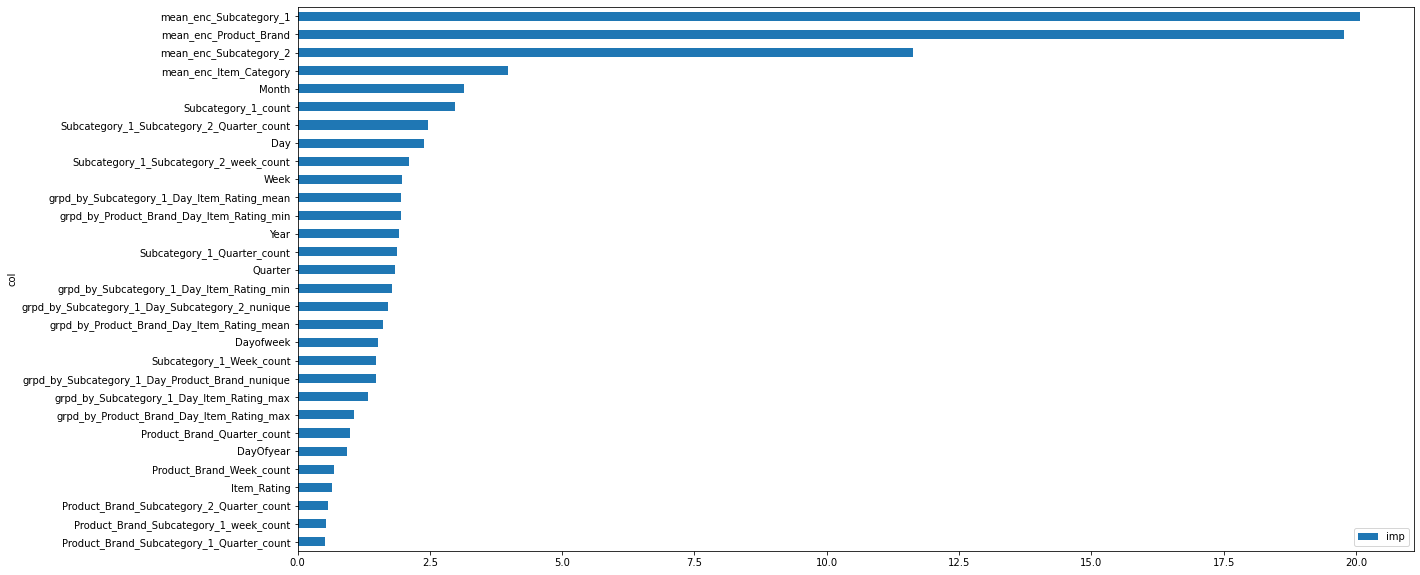

In [817]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': cols})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png') 

In [0]:
# # Fill the is_pass variable with the predictions
sub_df['Selling_Price']= pd.DataFrame((cat_pred))

# # Converting the submission file to excel format
sub_df.to_excel('cb_preds.xlsx', index=False)

### K-Fold

In [0]:
# lr = 0.033644

In [0]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [0]:
def runCatBoost(x_train, y_train,x_test, y_test,test,depth):
    model=CatBoostRegressor(iterations=1500,
                            # learning_rate=0.033644,
                            depth=depth,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            random_seed=99,
                            od_type='Iter',
                            od_wait=50)
    model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, verbose=False)
    y_pred_train=model.predict(x_test)
    rmsle_result = rmsle(np.exp(y_pred_train)-1,np.exp(y_test)-1)
    y_pred_test=model.predict(test)
    return y_pred_train,rmsle_result,y_pred_test

In [460]:
pred_full_test_cat_feen = 0
mse_cat_list_feen=[]
# kf = StratifiedKFold(n_splits=10,random_state=1,shuffle=True)
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = y[dev_index], y[val_index]
    y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test_X,depth=4)
    mse_cat_list_feen.append(rmsle_feen)
    pred_full_test_cat_feen = pred_full_test_cat_feen + y_pred_test_feen
mse_cat_feen_mean=np.mean(mse_cat_list_feen)
print("Mean cv score : ", np.mean(mse_cat_feen_mean))
y_pred_test_feen=pred_full_test_cat_feen/10

Mean cv score :  0.6391184936831195


In [0]:
# Mean cv score :  0.6391184936831195

In [462]:
np.expm1(y_pred_test_feen)

array([2184.89515298,  637.161703  ,  658.98487243, ..., 1379.87264126,
        449.68890669, 1428.07862424])

In [0]:
# # Fill the is_pass variable with the predictions
sub_df['Selling_Price']= pd.DataFrame((np.expm1(y_pred_test_feen)))

# # Converting the submission file to excel format
sub_df.to_excel('cb_10foldcv_preds.xlsx', index=False)

In [464]:
import math
# Target Variable
Y = train_df["Selling_Price"].values
# This performs binning of the target variable
# which defines a set of "classes" for the dataset
Y_classes = [math.ceil(i/20000)-1 for i in train_df["Selling_Price"].values]

print(X.shape, test_X.shape, Y.shape)

(2452, 33) (1051, 33) (2452,)


In [465]:
np.unique(Y_classes, return_counts=True)

(array([0, 1, 2, 3, 5]), array([2335,  110,    2,    4,    1]))

In [0]:
# !pip install reg_resampler

In [0]:
# import math
# # Target Variable
# Y = train_df["Selling_Price"].values
# # This performs binning of the target variable
# # which defines a set of "classes" for the dataset
# Y_classes = [math.ceil(i/20000)-1 for i in train_df["Selling_Price"].values]

# # print(X_train.shape, X_test.shape, Y.shape)

In [0]:
# print(Y_classes)

#### LightGM

In [0]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error

In [0]:
def rmse(y_true, y_pred):
    return metrics.mean_squared_error(y_true, y_pred) ** 0.5

In [740]:
training_start_time = time.time()

max_iter = 20
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(X))
test_preds = np.zeros(len(test_X))
target = train_df['Selling_Price'].values
train = X.copy()
test = test_X.copy()
features = X.columns
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.iloc[trn_idx][features], target[trn_idx]
    X_val, y_val = train.iloc[val_idx][features], target[val_idx]
    X_test = test[features]
    print(X_trn.shape[1], X_val.shape[1])
    
    
    clf = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.02, 
                        colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
    _ = clf.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=200, eval_metric='rmse')

    oofs[val_idx] = np.exp(clf.predict(X_val))
    current_test_pred = np.exp(clf.predict(X_test))
    test_preds += np.exp(clf.predict(X_test))/max_iter
    
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

42 42
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.639482	valid_0's l2: 0.408937
[200]	valid_0's rmse: 0.630784	valid_0's l2: 0.397888
[300]	valid_0's rmse: 0.641549	valid_0's l2: 0.411586
Early stopping, best iteration is:
[152]	valid_0's rmse: 0.627624	valid_0's l2: 0.393912

 Fold 0.6276237499963379

->-> Fold ran for 0 minutes 1 seconds

---- Fold 1 -----

42 42
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's rmse: 0.670644	valid_0's l2: 0.449764
[200]	valid_0's rmse: 0.63278	valid_0's l2: 0.400411
[300]	valid_0's rmse: 0.627819	valid_0's l2: 0.394156
[400]	valid_0's rmse: 0.627355	valid_0's l2: 0.393575
[500]	valid_0's rmse: 0.627905	valid_0's l2: 0.394265
Early stopping, best iteration is:
[334]	valid_0's rmse: 0.626687	valid_0's l2: 0.392736

 Fold 0.6266865699791477

->-> Fold ran for 0 minutes 1 seconds

---- Fold 2 -----

42 42
Training until validation scores don't improve for 200 ro

In [0]:
# OOF val score: 0.6224587398588455
# OOF val score: 0.6169674711844719
# OOF val score: 0.617002073530346 -- not trusted-quarter

In [0]:
vp0, tp0 = oofs, test_preds

#### Catboost

In [0]:
# categorical_features_indices = [1,2,3,4,5,6,7,14,15]
# model=CatBoostRegressor(iterations=1500, loss_function= 'RMSE', random_seed=1)

# model.fit(X, y,cat_features=categorical_features_indices,plot=True)

In [0]:
categorical_features_indices = [1,2,3,4,5,6,7,14,15]

In [743]:
training_start_time = time.time()

max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
test_preds = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.loc[trn_idx][features], target[trn_idx]
    X_val, y_val = train.loc[val_idx][features], target[val_idx]
    X_test = test[features]
    print(X_trn.shape[1], X_val.shape[1])
    
    
    
    clf = CatBoostRegressor(iterations=1500, loss_function= 'RMSE', random_seed=1)
    _ = clf.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, 
                early_stopping_rounds=200,cat_features=categorical_features_indices)

    oofs[val_idx] = np.exp(clf.predict(X_val))
    current_test_pred = np.exp(clf.predict(X_test))
    test_preds += np.exp(clf.predict(X_test))/max_iter
    
    
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

42 42
Learning rate set to 0.041565
0:	learn: 1.1440601	test: 1.2144620	best: 1.2144620 (0)	total: 8.03ms	remaining: 12s
100:	learn: 0.6300986	test: 0.6737798	best: 0.6737798 (100)	total: 722ms	remaining: 10s
200:	learn: 0.5855116	test: 0.6634149	best: 0.6634149 (200)	total: 1.45s	remaining: 9.39s
300:	learn: 0.5529197	test: 0.6575937	best: 0.6569038 (270)	total: 2.15s	remaining: 8.57s
400:	learn: 0.5131863	test: 0.6557447	best: 0.6556525 (399)	total: 2.94s	remaining: 8.04s
500:	learn: 0.4815686	test: 0.6553999	best: 0.6549656 (464)	total: 3.68s	remaining: 7.34s
600:	learn: 0.4512678	test: 0.6522670	best: 0.6521370 (598)	total: 4.4s	remaining: 6.58s
700:	learn: 0.4264440	test: 0.6542394	best: 0.6519428 (605)	total: 5.14s	remaining: 5.87s
800:	learn: 0.4066167	test: 0.6544585	best: 0.6519428 (605)	total: 5.89s	remaining: 5.14s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.6519428332
bestIteration = 605

Shrink model to first 606 iterations.

 F

In [0]:
# OOF val score: 0.6461008593728336
# OOF val score: 0.6448390715399193
# OOF val score: 0.639214717186197
# OOF val score: 0.6357359202328949 -- not trusted - quarter

In [0]:
vp1, tp1 = oofs, test_preds

### XGBoost

In [339]:
training_start_time = time.time()

max_iter = 10
folds = StratifiedKFold(n_splits = max_iter)
oofs = np.zeros(len(train))
test_preds = np.zeros(len(test))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False, duplicates='drop'))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_trn, y_trn = train.loc[trn_idx][features], target[trn_idx]
    X_val, y_val = train.loc[val_idx][features], target[val_idx]
    X_test = test[features]
    print(X_trn.shape[1], X_val.shape[1])
    

    clf = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.05, colsample_bytree=0.45)
    _ = clf.fit(X_trn, np.log(y_trn), eval_set = [(X_val, np.log(y_val))], verbose=100, early_stopping_rounds=200, eval_metric='rmse')
    

    oofs[val_idx] = np.exp(clf.predict(X_val))
    current_test_pred = np.exp(clf.predict(X_test))
    test_preds += np.exp(clf.predict(X_test))/max_iter
    
    
    print(f'\n Fold {rmse(np.log(y_val), np.log(oofs[val_idx]))}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total training time: {(total_training_time)//60} minutes {(total_training_time)%60} seconds')


---- Fold 0 -----

44 44
[18:54:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.01302
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.677947
[200]	validation_0-rmse:0.674561
[300]	validation_0-rmse:0.676367
Stopping. Best iteration:
[136]	validation_0-rmse:0.672928


 Fold 0.6729283842935968

->-> Fold ran for 0 minutes 2 seconds

---- Fold 1 -----

44 44
[18:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.95327
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.728386
[200]	validation_0-rmse:0.72797
[300]	validation_0-rmse:0.729122
Stopping. Best iteration:
[148]	validation_0-rmse:0.727209


 Fold 0.7272093163565799

->-> Fold ran for 0 minutes 2 seconds

---- Fold 2 -----

44 44
[18:54:27] WARNING: /workspac

In [0]:
# OOF val score: 0.631540133907891
# OOF val score: 0.6285514250627223
# OOF val score: 0.6284318109466082 -- not trusted (quarter )

In [0]:
vp2, tp2 = oofs, test_preds

In [168]:
np.corrcoef(tp1, tp2)

array([[1.        , 0.99266697],
       [0.99266697, 1.        ]])

In [0]:
test_preds = tp0*0.4 + tp1*0.3 + tp2*0.3

In [484]:
print(f'\nOOF val score: {rmse(np.log(target), np.log(oofs))}')


OOF val score: 0.631540133907891


In [485]:

print(f'\nOOF val score: {rmse(np.log(target), np.log(vp0*0.4 + vp1*0.3 + vp2*0.3))}')


OOF val score: 0.6200495098732719


In [0]:
# print(f'\nOOF val score: {rmse(np.log(target), np.log(vp0*0.3 + vp1*0.4 + vp2*0.3))}')
# OOF val score: 0.6230346582999723

In [487]:
test_preds

array([2467.78223999,  578.41503659,  771.19112623, ..., 1408.28516179,
        442.88954359, 1421.99383499])

In [0]:
# # Fill the is_pass variable with the predictions
sub_df['Selling_Price']= pd.DataFrame(test_preds)

# # Converting the submission file to excel format
sub_df.to_excel('lgbm_cb_xgb_403030.xlsx', index=False)

#### Predictions for all Algorithms

In [819]:
#train catboost model with categorical features on X,y
from catboost import CatBoostRegressor

categorical_features_indices = [1,2,3,4,5,6,7,14,15]
cat=CatBoostRegressor(iterations=1500, loss_function= 'RMSE', random_seed=1)

cat.fit(X, y,cat_features=categorical_features_indices,plot=True)
cat_preds=cat.predict(test_X)

    

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.033644
0:	learn: 1.1539999	total: 12.5ms	remaining: 18.8s
1:	learn: 1.1317043	total: 22.9ms	remaining: 17.2s
2:	learn: 1.1110631	total: 34.9ms	remaining: 17.4s
3:	learn: 1.0913718	total: 48.3ms	remaining: 18.1s
4:	learn: 1.0723173	total: 63.3ms	remaining: 18.9s
5:	learn: 1.0534449	total: 74.7ms	remaining: 18.6s
6:	learn: 1.0366013	total: 101ms	remaining: 21.5s
7:	learn: 1.0203869	total: 118ms	remaining: 22s
8:	learn: 1.0039072	total: 131ms	remaining: 21.7s
9:	learn: 0.9898538	total: 147ms	remaining: 21.9s
10:	learn: 0.9748532	total: 158ms	remaining: 21.4s
11:	learn: 0.9619299	total: 168ms	remaining: 20.8s
12:	learn: 0.9476285	total: 178ms	remaining: 20.3s
13:	learn: 0.9333351	total: 187ms	remaining: 19.8s
14:	learn: 0.9217900	total: 210ms	remaining: 20.8s
15:	learn: 0.9099744	total: 218ms	remaining: 20.2s
16:	learn: 0.8988391	total: 225ms	remaining: 19.7s
17:	learn: 0.8877491	total: 233ms	remaining: 19.2s
18:	learn: 0.8773603	total: 240ms	remaining: 18.7s
19:	lea

In [0]:
lg = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.02,
                    colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
lg.fit(X, y, eval_metric='rmse')
lg_preds = lg.predict(test_X)

In [0]:
test_preds = cat_preds*0.6 + lg_preds*0.4 

# # Fill the is_pass variable with the predictions
sub_df['Selling_Price']= pd.DataFrame(np.expm1(test_preds))

# # Converting the submission file to excel format
sub_df.to_excel('cb_lg_6040.xlsx', index=False)

In [961]:
xgb = XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.05, colsample_bytree=0.45)
xgb.fit(X, y,  eval_metric='rmse')
xgb_preds = xgb.predict(test_X)

test_preds = cat_preds*0.5 + lg_preds*0.3 + xgb_preds*0.2

# # Fill the is_pass variable with the predictions
sub_df['Selling_Price']= pd.DataFrame(np.expm1(test_preds))

# # Converting the submission file to excel format
sub_df.to_excel('cb_lg_xgb_503020_v6.xlsx', index=False)

[15:08:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [502]:
np.expm1(test_preds)

array([2533.14284467,  578.41041903,  791.43804452, ..., 1486.30150129,
        513.39350555, 1482.71654677])

In [0]:
 clf = LGBMRegressor(n_estimators=1000, num_leaves=127, max_depth=-1,min_child_samples=4, learning_rate=0.02,
                    colsample_bytree=0.4, reg_alpha=0.5, reg_lambda=2)
clf.fit(X_train, y_train, eval_set = [(X_valid, np.log(y_valid))], early_stopping_rounds=200,verbose=100,
        eval_metric='rmse')
pred=clf.predict(test_X)
pred_lgbm = pred

In [257]:
np.expm1(pred_lgbm)

array([2838.6928928 ,  506.12667157,  847.64403263, ..., 1552.02308619,
        482.11694997, 1523.83895642])

In [0]:
# # Fill the is_pass variable with the predictions
sub_df['Selling_Price']= pd.DataFrame((np.expm1(pred_lgbm)))

# # Converting the submission file to excel format
sub_df.to_excel('lgbm.xlsx', index=False)

### Check resmpaling

In [63]:
resampled_train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


In [64]:
resampled_test_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date
0,P-11284,B-2984,computers,network components,routers,4.3,1/12/2018
1,P-6580,B-1732,jewellery,bangles bracelets armlets,bracelets,3.0,20/12/2012
2,P-5843,B-3078,clothing,women s clothing,western wear,1.5,1/12/2014
3,P-5334,B-1421,jewellery,necklaces chains,necklaces,3.9,1/12/2019
4,P-5586,B-3078,clothing,women s clothing,western wear,1.4,1/12/2017


In [65]:
resampled_train_df.columns

Index(['Product', 'Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2', 'Item_Rating', 'Date', 'Selling_Price'],
      dtype='object')

In [66]:
cols = ['Product','Product_Brand', 'Item_Category', 'Subcategory_1',
       'Subcategory_2']
for col in cols:
    if resampled_train_df[col].dtype==object:
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(resampled_train_df[col].values.astype('str')) + list(resampled_test_df[col].values.astype('str')))
        resampled_train_df[col] = lbl.transform(list(resampled_train_df[col].values.astype('str')))
        resampled_test_df[col] = lbl.transform(list(resampled_test_df[col].values.astype('str')))

Product
Product_Brand
Item_Category
Subcategory_1
Subcategory_2


In [0]:
resampled_train_df['Date'] = pd.to_datetime(resampled_train_df['Date'])
resampled_test_df['Date'] = pd.to_datetime(resampled_test_df['Date'])

In [68]:
!pip install reg_resampler==1.0.7

In [69]:
resampled_train_df.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,1154,1130,9,11,159,4.3,2017-02-03,291.0
1,1109,877,17,139,387,3.1,2015-07-01,897.0
2,2499,369,38,119,118,3.5,2019-01-12,792.0
3,1732,877,12,40,155,4.0,2014-12-12,837.0
4,3016,877,17,86,344,4.3,2013-12-12,470.0


In [0]:
resampled_train_df.drop(['Date'],axis=1,inplace=True)
resampled_test_df.drop(['Date'],axis=1,inplace=True)

In [71]:
resampled_train_df.dtypes

Product            int64
Product_Brand      int64
Item_Category      int64
Subcategory_1      int64
Subcategory_2      int64
Item_Rating      float64
Selling_Price    float64
dtype: object

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from imblearn.over_sampling import SMOTE, KMeansSMOTE, RandomOverSampler, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
# from imblearn.combine import SMOTETomek
from reg_resampler import resampler
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
# from ngboost import NGBRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [0]:
# from reg_resampler import resampler
# rs = resampler()
# target = "Selling_Price"
# df_train_ = rs.fit(resampled_train_df,target , bins =5)
# #you can try this if u dont want to generate many samples
# # df_train_ = rs.fit(train,target , bins =5,balanced_binning=True)
# smote = SMOTE(random_state=27)
# df_train_ = rs.resample(smote)
# print("Before Resample",train.shape)
# print("After Resample ",df_train_.shape)

In [74]:
from reg_resampler import resampler
from imblearn.over_sampling import SMOTE 

# Initialize the resampler object
rs = resampler()
target = "Selling_Price"
# Returned dataframe contains a new column called "classes"
# The function also prints the class distribution
# This is for analysis purpose
df_train_ = rs.fit(resampled_train_df, target, bins=5)

# Create a smote (over-sampling) object from imblearn
smote = SMOTE(random_state=27)

# Now resample
# You might recieve warning about class merger for low sample classes
df_train_ = rs.resample(smote)
df_train_.head()

Class Distribution:
-------------------
0: 2350
1: 96
2: 4
3: 1
4: 1


,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Selling_Price
0,1154.0,1130.0,9.0,11.0,159.0,4.3,291.0
1,1109.0,877.0,17.0,139.0,387.0,3.1,897.0
2,2499.0,369.0,38.0,119.0,118.0,3.5,792.0
3,1732.0,877.0,12.0,40.0,155.0,4.0,837.0
4,3016.0,877.0,17.0,86.0,344.0,4.3,470.0


In [75]:
print("Before Resample",resampled_train_df.shape)
print("After Resample ",df_train_.shape)

Before Resample (2452, 7)
After Resample  (4700, 7)


In [78]:
#initialise the reg_sampler package
rs = resampler()
from collections import Counter
binstrain = rs.fit(resampled_train_df, "Selling_Price", bins=5)
orgi = Counter(binstrain["classes"])
print(orgi)

Class Distribution:
-------------------
0: 2350
1: 96
2: 4
3: 1
4: 1
Counter({0: 2350, 1: 96, 2: 4, 4: 1, 3: 1})


In [0]:
smote = SMOTE({0:orgi[0]*4,
               1:orgi[1]*1000,
               2:orgi[2]*2000,
               3:orgi[3]*2000,
               4:orgi[4]*200},random_state=27)
               
# df_train_ =rs.resample(smote)

In [90]:
smote

SMOTE(k_neighbors=5, kind='deprecated', m_neighbors='deprecated', n_jobs=1,
      out_step='deprecated', random_state=27, ratio=None,
      sampling_strategy={0: 9400, 1: 96000, 2: 8000, 3: 2000, 4: 200},
      svm_estimator='deprecated')

In [91]:
df_train_ =rs.resample(smote)

ValueError: ignored